# **Neuro-Symbolic Spatial Reasoning with LTNtorch**

> **This notebook implements a Neuro-Symbolic Agent in a simplified Logical Tensor Network (LTN) for spatial reasoning CLEVR-like.**

# **Notes**

> **This is a standalone educational implementation that intentionally uses simple fuzzy semantics instead of the full LTNtorch library.\
\
For reproducibility/experimentation adjust hyperparameters in the *Demo Mode* cell.\
\
In the Final Results section, after the code cell has finished executing, the results are generated and stored in a CSV file that can be found in the Colab Files tab with the name "ltn_experiments_results".**

# **Summary**

> - [**1 — Imports & Utils**](#scrollTo=nvxZZ2ZmDSDP)
>   - [**1.1 — Imports**](#scrollTo=hTRSbfppZDcU)
>   - [**1.2 — Utils**](#scrollTo=jl7v461pZJAI)
> - [**2 — The Data Structure**](#scrollTo=MRCo9bCJDlJ2)
>   - [**2.1 — Dataset Generator**](#scrollTo=E_goZXvvJdkS)
>   - [**2.2 — Dataset Plotting**](#scrollTo=F9NelndJMWI5)
> - [**3 — Main Tasks**](#scrollTo=W7skzjqGM2gI)
>	  - [**3.1 — Task 1: Taxonomy & Shapes**](#scrollTo=IhQRYeN-Nqao)
>	    - [**3.1.1 — Data generation**](#scrollTo=zF9bMx_2OCnA)
>	    - [**3.1.2 — Predicates**](#scrollTo=ejp6diiuPCaD)
>	    - [**3.1.3 — Axioms**](#scrollTo=jhhDr132PSeu)
>	  - [**3.2 — Task 2: Spatial Reasoning**](#scrollTo=E9jHpp4eQXt0)
>	    - [**3.2.1 — Predicates**](#scrollTo=RNIiIs_gQaT7)
>	    - [**3.2.2 — Axioms**](#scrollTo=oumv9hS5QjQz)
>	  - [**3.3 — Task 3: Horizontal Reasoning**](#scrollTo=f6Z9tyb3Qqkb)
>	  - [**3.4 — Task 4: Vertical Reasoning**](#scrollTo=pnYo2hdRQ75t)
>	    - [**3.4.1 — Predicates**](#scrollTo=48TukLZ3XjG-)
>	    - [**3.4.2 — Axioms**](#scrollTo=DA05tJOjXskz)
>	  - [**3.5 — Task 5: Compound Reasoning**](#scrollTo=1lb921QbSxzv)
> - [**4 — Training & Evaluate**](#scrollTo=2utzeQmfRgsJ)
>	  - [**4.1 — Training**](#scrollTo=IkMEX9SJbGVv)
>	  - [**4.2 — Evaluate**](#scrollTo=kTAxLL_fbLi-)
> - [**5 — Results**](#scrollTo=YP8_IeURbXm8)
>	  - [**5.1 — Loop Function**](#scrollTo=VBuozQnxb-32)
>	  - [**5.2 — Demo Mode**](#scrollTo=nkDlqtMdcL52)
>	  - [**5.3 — Results Finals**](#scrollTo=1G7RDAMhcQ-1)


# **1 — Imports & Utils**


## **1.1 — Imports**

In [1]:
# DEPENDENCIES (If the runtime environment is new, uncomment the line below and execute it.)
#!pip install torch torchvision matplotlib pandas scikit-learn tqdm

# IMPORTS
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import trange

# SETUPS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cpu


## **1.2 — Utils**

In [2]:
# Fuzzy logic helpers (differentiable)

# Negation
def neg(x):
    return 1.0 - x

# Conjuntion
def conj(x, y, mode='prod'):
    # conjunction: product or minimum
    if mode == 'prod':
        return x * y
    elif mode == 'min':
        return torch.min(x, y)
    else:
        raise ValueError('unknown mode')

# Disjution
def disj(x, y, mode='max'):
    if mode == 'max':
        return torch.max(x, y)
    elif mode == 'prob':
        # probabilistic sum
        return x + y - x * y
    else:
        raise ValueError('unknown mode')

# Universal quantifier: average truth across domain (returns scalar in [0,1])
def forall(truth_vals):
    # truth_vals: tensor of shape (N,) or (N, )
    return truth_vals.mean()

# Existential: max
def exists(truth_vals):
    return truth_vals.max()

# Aggregation for a set of groundings (we'll use mean)
def sat_agg(values):
    return values.mean()

# Predicate neural models
class UnaryPredicate(nn.Module):
    def __init__(self, input_dim=11, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )
    # Forward
    def forward(self, x):
        # x shape: (N, input_dim)
        return self.net(x).squeeze(-1)

# **2 — The Data Structure**

## **2.1 — Dataset Generator**

In [3]:
def generate_scene(n_objects=25, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    objs = []          # feature vectors
    shape_labels = []  # 0:circle, 1:square, 2:cylinder, 3:cone, 4:triangle
    color_labels = []  # 0:red, 1:green, 2:blue
    size_labels = []   # 0 small, 1 big

    for i in range(n_objects):                            # generated objects
        x = float(np.random.rand())
        y = float(np.random.rand())
        color = np.random.randint(0, 3)
        shape = np.random.randint(0, 5)
        size = np.random.choice([0.0, 1.0], p=[0.7, 0.3]) # 70% small vs 30% large proportion

        feat = np.zeros(11, dtype=float)                  # object in vector indices
        feat[0] = x
        feat[1] = y
        feat[2 + color] = 1.0
        feat[5 + shape] = 1.0
        feat[10] = size

        objs.append(feat)                                 # appending the vector object to the feature vector
        shape_labels.append(shape)
        color_labels.append(color)
        size_labels.append(int(size > 0.5))

    feats = np.stack(objs, axis=0)
    labels = {
        'shape': np.array(shape_labels, dtype=int),
        'color': np.array(color_labels, dtype=int),
        'size': np.array(size_labels, dtype=int),
        'pos': feats[:, :2].copy()
    }
    return feats, labels

## **2.2 — Dataset Plotting**

In [4]:
def plot_scene(feats, labels=None, title='Scene'):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(title)

    shape_map = {0:'o', 1:'s', 2:'D', 3:'^', 4:'p'}
    color_map = {0:'red',1:'green',2:'blue'}

    for i, f in enumerate(feats):
        x, y = f[0], f[1]
        shape = int(np.argmax(f[5:10]))
        color = int(np.argmax(f[2:5]))
        size = 80 if f[10] > 0.5 else 40
        ax.scatter(x, y, s=size, marker=shape_map[shape], color=color_map[color], edgecolor='k')
        ax.text(x + 0.01, y + 0.01, f'o{i+1}', fontsize=8)

    plt.show()

# **3 — Main Tasks**

## **3.1 — Task 1: Taxonomy & Shapes**


### **3.1.1 — Data generation**

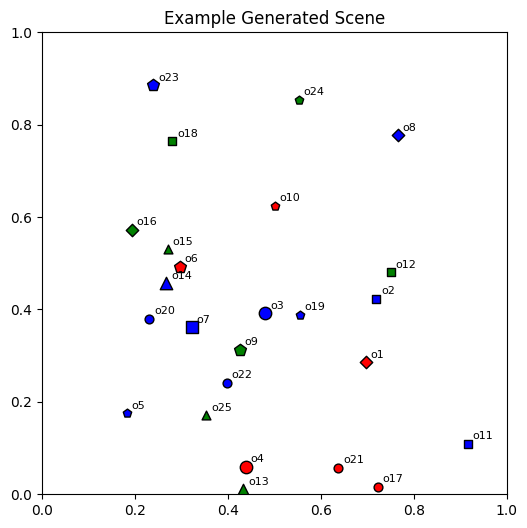

In [5]:
feats, labels = generate_scene(n_objects=25, seed=123)
plot_scene(feats, labels, title='Example Generated Scene')

### **3.1.2 — Predicates**

In [6]:
def build_predicates(input_dim=11):
    unary = {
        # forms
        'isCircle': UnaryPredicate(input_dim).to(device),
        'isSquare': UnaryPredicate(input_dim).to(device),
        'isCylinder': UnaryPredicate(input_dim).to(device),
        'isCone': UnaryPredicate(input_dim).to(device),
        'isTriangle': UnaryPredicate(input_dim).to(device),
        # sizes
        'isSmall': UnaryPredicate(input_dim).to(device),
        'isBig': UnaryPredicate(input_dim).to(device),
        # colors
        'isRed': UnaryPredicate(input_dim).to(device),
        'isGreen': UnaryPredicate(input_dim).to(device),
        'isBlue': UnaryPredicate(input_dim).to(device),
         # Stack
        'isStackable': UnaryPredicate(input_dim).to(device),
    }
    return unary

### **3.1.3 — Axioms**

In [7]:
# Logical formulas implemented as Python functions (return tensor truth in [0,1])

# Unique form
def formula_uniqueness(unaries, X):
    # For each x: not (two shapes simultaneously)
    # compute for shape preds only
    shapes = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
    preds = [unaries[s](X) for s in shapes]  # list of tensors (N,)
    stacked = torch.stack(preds, dim=1)  # (N,5)
    # conjunction of any pair -> sum over pairs
    pairwise_and = []
    for i in range(stacked.size(1)):
        for j in range(i+1, stacked.size(1)):
            pairwise_and.append(stacked[:,i] * stacked[:,j])
    if len(pairwise_and) == 0:
        return torch.tensor(1.0, device=device)
    pairwise = torch.stack(pairwise_and, dim=1).sum(dim=1)
    # want not(pairwise) for each x
    per_x = 1.0 - torch.clamp(pairwise, 0.0, 1.0)
    return forall(per_x)

# Coverage
def formula_coverage(unaries, X):
    shapes = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
    preds = [unaries[s](X) for s in shapes]
    stacked = torch.stack(preds, dim=1)
    per_x = torch.clamp(stacked.sum(dim=1), 0.0, 1.0)
    # we want per_x to be close to 1 (at least one true)
    return forall(per_x)

## **3.2 — Task 2: Spatial Reasoning**

### **3.2.1 — Predicates**

In [8]:
# Binary geometric predicates implemented differentiably using positions

# leftOf(x, y)
def left_of_truth(pos_x, pos_y, sharpness=40.0):
    # pos_x, pos_y: (N,2) tensors
    # returns in (0,1) high when x < y
    dx = pos_y[:,0] - pos_x[:,0]  # positive if x<y
    return torch.sigmoid(sharpness * dx)

# rightOf(x, y)
def right_of_truth(pos_x, pos_y, sharpness=40.0):
    return left_of_truth(pos_y, pos_x, sharpness)

# closeTo(x, y)
def close_to_truth(pos_x, pos_y, sigma=0.2):
    dist2 = ((pos_x - pos_y)**2).sum(dim=1)
    return torch.exp(-2.0 * dist2 / (sigma**2))

# inBetween(x, y, z)
# inBetween: x is between y and z horizontally OR vertically OR roughly on segment
def in_between_truth(pos_x, pos_y, pos_z):
    # Use two checks: x between on x-axis or y-axis
    cond1 = (left_of_truth(pos_y, pos_x) * left_of_truth(pos_x, pos_z)) + (left_of_truth(pos_z, pos_x) * left_of_truth(pos_x, pos_y))
    # cond1 is fuzzy; clamp to [0,1]
    return torch.clamp(cond1, 0.0, 1.0)

### **3.2.2 — Axioms**

In [9]:
# Irreflexivity
def formula_irreflexive_left(unaries, positions):
    # For all x: not LeftOf(x,x)
    N = positions.size(0)
    pos = positions
    vals = left_of_truth(pos, pos)
    per_x = 1.0 - vals
    return forall(per_x)

#Asymmetry
def formula_asymmetry_left(unaries, positions):
    # For all x,y: LeftOf(x,y) => not LeftOf(y,x)
    pos = positions
    N = pos.size(0)
    # compute matrix of pairwise truths
    px = pos.unsqueeze(1).repeat(1,N,1)
    py = pos.unsqueeze(0).repeat(N,1,1)
    px_flat = px.reshape(-1,2)
    py_flat = py.reshape(-1,2)
    left_xy = left_of_truth(px_flat, py_flat)
    left_yx = left_of_truth(py_flat, px_flat)
    # implication a => b interpreted as 1 - a + a*b  (Lukasiewicz/prob variants)
    impl = 1.0 - left_xy + left_xy * (1.0 - left_yx)
    # alternative simpler: not (left_xy and left_yx)
    per_pair = 1.0 - (left_xy * left_yx)
    return forall(per_pair)

# Inverse
def formula_inverse(unaries, positions):
    # For all x,y: LeftOf(x,y) iff RightOf(y,x)
    N = positions.size(0)
    px = positions.unsqueeze(1).repeat(1,N,1).reshape(-1,2)
    py = positions.unsqueeze(0).repeat(N,1,1).reshape(-1,2)
    left_xy = left_of_truth(px, py)
    right_yx = right_of_truth(py, px)
    per_pair = 1.0 - torch.abs(left_xy - right_yx)
    return forall(per_pair)

# Transitivity
def formula_transitivity(unaries, positions):
    # For all x,y,z: left(x,y) & left(y,z) => left(x,z)
    N = positions.size(0)
    pos = positions
    p1 = pos.unsqueeze(1).unsqueeze(2).repeat(1,N,N,1).reshape(-1,2)  # x
    p2 = pos.unsqueeze(0).unsqueeze(2).repeat(N,1,N,1).reshape(-1,2)  # y
    p3 = pos.unsqueeze(0).unsqueeze(1).repeat(N,N,1,1).reshape(-1,2)  # z
    left_xy = left_of_truth(p1, p2)
    left_yz = left_of_truth(p2, p3)
    left_xz = left_of_truth(p1, p3)
    # implication (left_xy & left_yz) => left_xz
    antecedent = left_xy * left_yz
    per_triplet = 1.0 - antecedent + antecedent * left_xz
    return forall(per_triplet)

## **3.3 — Task 3: Horizontal Reasoning**

In [10]:
# closeTo(x, y)
def formula_closeTo(positions, sigma=0.1):
    N = positions.size(0)
    pos = positions
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2)
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2)
    vals = close_to_truth(px, py, sigma=sigma)
    # remove diagonal
    mask = 1 - torch.eye(N, device=device).reshape(-1)
    masked = vals * mask
    return sat_agg(masked)

# inBetween(x, y, z)
def formula_inBetween(positions):
    N = positions.size(0)
    pos = positions
    # compute for all triples x,y,z where x is candidate between y and z
    p_x = pos.unsqueeze(1).unsqueeze(2).repeat(1,N,N,1).reshape(-1,2)
    p_y = pos.unsqueeze(0).unsqueeze(2).repeat(N,1,N,1).reshape(-1,2)
    p_z = pos.unsqueeze(0).unsqueeze(1).repeat(N,N,1,1).reshape(-1,2)
    vals = in_between_truth(p_x, p_y, p_z)
    return sat_agg(vals)

# lastOnTheLeft(x)
def formula_last_on_left(positions):
    N = positions.size(0)
    pos = positions
    # for each candidate x, check forall y LeftOf(x,y)
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2)
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2)
    left_xy = left_of_truth(px, py)
    left_xy = left_xy.reshape(N,N)
    per_x = left_xy.mean(dim=1)  # approximate forall by mean
    return exists(per_x)

# lastOnTheRight(x)
def formula_last_on_right(positions):
    N = positions.size(0)
    pos = positions
    # for each candidate x, check forall y RightOf(x,y)
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2)
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2)
    right_xy = right_of_truth(px, py)
    right_xy = right_xy.reshape(N,N)
    per_x = right_xy.mean(dim=1)  # approximate forall by mean
    return exists(per_x)

# Existential consultation
def formula_exists_left_of_all_squares(unaries, positions, X):
    # 1. Define function (done by wrapper)
    # 2. Get the number of objects N
    N = positions.size(0)
    pos = positions

    # 3. Obtain the truth values for IsSquare(y)
    isSquare_vals = unaries['isSquare'](X) # (N,)

    # 4. Prepare px and py tensors for pairwise comparisons
    # px will be for x, py will be for y
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2) # (N*N, 2) where each x is repeated N times
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2) # (N*N, 2) where each y is repeated N times

    # 5. Calculate the LeftOf(x,y) truth values
    left_xy = left_of_truth(px, py) # (N*N,)

    # 6. Reshape the left_of_truth results to an (N, N) matrix
    left_xy = left_xy.reshape(N,N) # left_xy[i,j] is LeftOf(obj_i, obj_j)

    # 7. For each x, compute the implication IsSquare(y) => LeftOf(x,y) for all y
    # a => b is 1 - a + a * b
    # 'a' is IsSquare(y), 'b' is LeftOf(x,y)
    # isSquare_vals needs to be (1, N) for broadcasting with left_xy (N,N)
    a_is_square_y = isSquare_vals.unsqueeze(0) # (1, N)
    b_left_of_xy = left_xy # (N, N)

    # implication_truth[x_idx, y_idx] = (IsSquare(obj_y) => LeftOf(obj_x, obj_y))
    per_xy_implication = (1.0 - a_is_square_y) + (a_is_square_y * b_left_of_xy)

    # 8. Approximate the universal quantifier (∀y, (...))
    # mean of implication truth values across all y for each x
    per_x_forall_y = per_xy_implication.mean(dim=1) # (N,)

    # 9. Apply the existential quantifier (∃x, ...) by taking the maximum
    return exists(per_x_forall_y)

# The Square-Circle Constraint
def formula_square_right_of_circle(unaries, positions, X):
    # 1. Define function (done by wrapper)
    # 2. Get the number of objects N
    N = positions.size(0)
    pos = positions

    # 3. Obtain the truth values for IsSquare(x) and IsCircle(y)
    isSquare_vals = unaries['isSquare'](X) # (N,)
    isCircle_vals = unaries['isCircle'](X) # (N,)

    # 4. Prepare px and py tensors for pairwise comparisons
    # For (x,y) pairs, we need x's position and y's position
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2) # (N*N, 2) where each x is repeated N times
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2) # (N*N, 2) where each y is repeated N times

    # 5. Calculate the RightOf(x,y) truth values
    right_xy = right_of_truth(px, py) # (N*N,)

    # 6. Reshape the RightOf results to an (N, N) matrix
    right_xy = right_xy.reshape(N,N) # right_xy[i,j] is RightOf(obj_i, obj_j)

    # 7. Compute the antecedent: IsSquare(x) AND IsCircle(y)
    # isSquare_vals_x needs to be (N, 1) to broadcast with isCircle_vals_y (1, N)
    isSquare_x_mat = isSquare_vals.unsqueeze(1) # (N, 1)
    isCircle_y_mat = isCircle_vals.unsqueeze(0) # (1, N)
    antecedent = isSquare_x_mat * isCircle_y_mat # (N, N) matrix of (IsSquare(x) AND IsCircle(y))

    # 8. Compute the implication: antecedent => RightOf(x,y)
    # a => b is 1 - a + a * b
    implication_truth = (1.0 - antecedent) + (antecedent * right_xy) # (N, N)

    # 9. Apply the universal quantifier (∀x,y) by taking the mean of all implication truth values
    return forall(implication_truth.flatten())

## **3.4 — Task 4: Vertical Reasoning**

### **3.4.1 — Predicates**

In [11]:
# above(x, y)
def above_truth(pos_x, pos_y, sharpness=40.0):
    dy = pos_y[:,1] - pos_x[:,1]
    return torch.sigmoid(sharpness * dy)

# below(x, y)
def below_truth(pos_x, pos_y, sharpness=40.0):
    return above_truth(pos_y, pos_x, sharpness)

### **3.4.2 — Axioms**

In [12]:
# Inverse
def formula_inverse_below_above(positions):
    # 1. Define function (done by wrapper)
    # 2. Determine the number of objects, N
    N = positions.size(0)
    pos = positions

    # 3. Create px and py tensors for pairwise comparisons
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2) # (N*N, 2) for x
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2) # (N*N, 2) for y

    # 4. Calculate the truth values for below(x,y)
    below_xy = below_truth(px, py)

    # 5. Calculate the truth values for above(y,x)
    above_yx = above_truth(py, px)

    # 6. Compute the fuzzy equivalence (iff) between below(x,y) and above(y,x)
    # A <=> B is 1 - |A - B|
    per_pair_equivalence = 1.0 - torch.abs(below_xy - above_yx)

    # 7. Apply the universal quantifier forall to the flattened tensor
    return forall(per_pair_equivalence)


# Transitivity
def formula_transitivity_below(positions):
    # 1. Define function (done by wrapper)
    # 2. Get the number of objects, N
    N = positions.size(0)
    pos = positions

    # 3. Create p1, p2, and p3 tensors for all possible triplets (x, y, z)
    # p1 for x: repeat x for each (y,z) pair
    p1 = pos.unsqueeze(1).unsqueeze(2).repeat(1, N, N, 1).reshape(-1, 2)
    # p2 for y: repeat y for each (x,z) pair
    p2 = pos.unsqueeze(0).unsqueeze(2).repeat(N, 1, N, 1).reshape(-1, 2)
    # p3 for z: repeat z for each (x,y) pair
    p3 = pos.unsqueeze(0).unsqueeze(1).repeat(N, N, 1, 1).reshape(-1, 2)

    # 4. Calculate the truth values for below(x,y)
    below_xy = below_truth(p1, p2)

    # 5. Calculate the truth values for below(y,z)
    below_yz = below_truth(p2, p3)

    # 6. Calculate the truth values for below(x,z)
    below_xz = below_truth(p1, p3)

    # 7. Compute the antecedent: below(x,y) AND below(y,z)
    antecedent = conj(below_xy, below_yz, mode='prod')

    # 8. Compute the implication: antecedent => below(x,z)
    # a => b is 1 - a + a * b
    implication_truth = (1.0 - antecedent) + (antecedent * below_xz)

    # 9. Apply the universal quantifier forall to the flattened tensor
    return forall(implication_truth)

# canStack
def formula_is_stackable_definition(unaries, X):
    # 1. Define function (done by wrapper)

    # 2. Obtain the truth values for isCone(y) and isTriangle(y)
    isCone_vals = unaries['isCone'](X) # (N,)
    isTriangle_vals = unaries['isTriangle'](X) # (N,)

    # 3. Calculate the negation of isCone(y) and isTriangle(y)
    not_isCone = neg(isCone_vals)
    not_isTriangle = neg(isTriangle_vals)

    # 4. Compute the conjunction of ¬isCone(y) and ¬isTriangle(y)
    antecedent_truth = conj(not_isCone, not_isTriangle, mode='prod') # (N,)

    # 5. Obtain the truth value for isStackable(y)
    isStackable_vals = unaries['isStackable'](X) # (N,)

    # 6. Compute the fuzzy equivalence (iff) between isStackable(y) and the calculated conjunction
    per_object_equivalence = 1.0 - torch.abs(isStackable_vals - antecedent_truth)

    # 7. Apply the forall quantifier to the resulting tensor of equivalence truths
    return forall(per_object_equivalence)

## **3.5 — Task 5: Compound Reasoning**

In [13]:
# Composed query: exists small below cylinder and left of square
def formula_composed_small_below_cyl_left_sq(unaries, positions, X):
    # returns truth for "exists x (IsSmall(x) & exists y(IsCylinder(y) & Below(x,y)) & exists z(IsSquare(z) & LeftOf(x,z)))"
    N = positions.size(0)
    isSmall_vals = unaries['isSmall'](X)
    isCylinder_vals = unaries['isCylinder'](X)
    isSquare_vals = unaries['isSquare'](X)

    # for every x compute conj of small and existence of y and z
    pos = positions
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2)
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2)

    below_xy = below_truth(px, py).reshape(N,N)
    left_xz = left_of_truth(px, py).reshape(N,N)

    # existence across y for each x: max over y of (isCylinder(y) & below(x,y))
    cyl_and_below = (isCylinder_vals.unsqueeze(0) * below_xy)
    exist_cyl = cyl_and_below.max(dim=1)[0]

    sq_and_left = (isSquare_vals.unsqueeze(0) * left_xz)
    exist_sq = sq_and_left.max(dim=1)[0]

    per_x = isSmall_vals * exist_cyl * exist_sq
    return exists(per_x)

# Absolute Position Deduction
def formula_exists_green_cone_in_between(unaries, positions, X):
    # 1. Define function (done by wrapper)

    # 2. Get the number of objects N
    N = positions.size(0)
    pos = positions

    # 3. Obtain the truth values for IsCone(x) and IsGreen(x)
    isCone_vals = unaries['isCone'](X)  # (N,)
    isGreen_vals = unaries['isGreen'](X)  # (N,)

    # 4. Prepare p_x, p_y, and p_z tensors for all possible triplets (x, y, z)
    # p_x for x: repeat x for each (y,z) pair
    p_x = pos.unsqueeze(1).unsqueeze(2).repeat(1, N, N, 1).reshape(-1, 2)
    # p_y for y: repeat y for each (x,z) pair
    p_y = pos.unsqueeze(0).unsqueeze(2).repeat(N, 1, N, 1).reshape(-1, 2)
    # p_z for z: repeat z for each (x,y) pair
    p_z = pos.unsqueeze(0).unsqueeze(1).repeat(N, N, 1, 1).reshape(-1, 2)

    # 5. Calculate the InBetween(x,y,z) truth values for all triplets
    in_between_xyz = in_between_truth(p_x, p_y, p_z)  # (N*N*N,)

    # 6. Combine the truth values using conjunction: IsCone(x) * IsGreen(x) * InBetween(x,y,z)
    # Reshape IsCone(x) and IsGreen(x) to broadcast correctly with the N*N*N triplets.
    # The N*N*N tensor corresponds to (x_idx, y_idx, z_idx).
    # We need isCone(x_idx) and isGreen(x_idx) to be repeated N*N times.
    isCone_x_broadcast = isCone_vals.unsqueeze(1).unsqueeze(2).repeat(1, N, N).reshape(-1)
    isGreen_x_broadcast = isGreen_vals.unsqueeze(1).unsqueeze(2).repeat(1, N, N).reshape(-1)

    # Compute the conjunction for all N*N*N triplets
    combined_truth = conj(conj(isCone_x_broadcast, isGreen_x_broadcast, mode='prod'), in_between_xyz, mode='prod')

    # 7. Apply the existential quantifier exists to the resulting tensor
    return exists(combined_truth)

# Proximity restriction (Part 1)
def formula_same_size(unaries, X):
    # 1. Define function (done by wrapper)

    # 2. Obtain the truth values for isSmall(x) for all objects
    isSmall_vals = unaries['isSmall'](X)  # (N,)

    # 3. Obtain the truth values for isBig(x) for all objects
    isBig_vals = unaries['isBig'](X)  # (N,)

    # 4. Expand isSmall_vals to isSmall_x (N, 1) and isSmall_y (1, N)
    isSmall_x = isSmall_vals.unsqueeze(1)
    isSmall_y = isSmall_vals.unsqueeze(0)

    # 5. Calculate fuzzy equivalence for isSmall: 1 - |isSmall_x - isSmall_y|
    eq_small = 1.0 - torch.abs(isSmall_x - isSmall_y)

    # 6. Repeat steps 4 and 5 for isBig_vals
    isBig_x = isBig_vals.unsqueeze(1)
    isBig_y = isBig_vals.unsqueeze(0)
    eq_big = 1.0 - torch.abs(isBig_x - isBig_y)

    # 7. Compute fuzzy conjunction (product) of eq_small and eq_big
    same_size_truth = conj(eq_small, eq_big, mode='prod')

    # 8. Return the same_size_truth tensor
    return same_size_truth


# Proximity restriction (Part 2)
def formula_triangle_close_same_size(unaries, positions, X):
    # 1. Get the number of objects, N
    N = positions.size(0)
    pos = positions

    # 2. Obtain the truth values for IsTriangle(x)
    isTriangle_vals = unaries['isTriangle'](X)  # (N,)

    # 3. Calculate the CloseTo(x,y) truth values for all pairs of objects
    px = pos.unsqueeze(1).repeat(1,N,1).reshape(-1,2) # (N*N, 2)
    py = pos.unsqueeze(0).repeat(N,1,1).reshape(-1,2) # (N*N, 2)
    close_to_xy = close_to_truth(px, py).reshape(N,N) # (N,N)

    # 4. Compute the antecedent part: IsTriangle(x) AND IsTriangle(y) AND CloseTo(x,y)
    isTriangle_x = isTriangle_vals.unsqueeze(1) # (N,1)
    isTriangle_y = isTriangle_vals.unsqueeze(0) # (1,N)
    antecedent = conj(conj(isTriangle_x, isTriangle_y, mode='prod'), close_to_xy, mode='prod') # (N,N)

    # 5. Calculate the SameSize(x,y) truth values for all pairs of objects
    same_size_xy = formula_same_size(unaries, X) # (N,N)

    # 6. Compute the fuzzy implication between the antecedent and SameSize(x,y)
    # A => B is 1 - A + A * B
    implication_truth = (1.0 - antecedent) + (antecedent * same_size_xy) # (N,N)

    # 7. Apply the universal quantifier forall to the flattened tensor
    return forall(implication_truth.flatten())

# **4 — Training & Evaluate**

## **4.1 — Training**

In [14]:
def train_ltn(unaries, feats, labels, epochs=500, lr=1e-3, weight_supervision=1.0, verbose=False):
    """Train unary predicate nets to satisfy logical formulas. We also include
    optional classification supervision (weight_supervision) to speed convergence.
    """
    feats_t = torch.tensor(feats, dtype=torch.float32, device=device)
    pos_t = feats_t[:, :2]

    params = []
    for p in unaries.values():
        params += list(p.parameters())
    optim_ = optim.Adam(params, lr=lr)

    history = []
    for ep in range(epochs):
        optim_.zero_grad()
        # compute formula truths
        f1 = formula_uniqueness(unaries, feats_t)
        f2 = formula_coverage(unaries, feats_t)
        f3 = formula_irreflexive_left(unaries, pos_t)
        f4 = formula_asymmetry_left(unaries, pos_t)
        f5 = formula_inverse(unaries, pos_t)
        f6 = formula_transitivity(unaries, pos_t)
        f7 = formula_closeTo(pos_t, sigma=0.15)
        f8 = formula_inBetween(pos_t)
        # Previously added formulas
        f9 = formula_last_on_right(pos_t)
        f10 = formula_exists_left_of_all_squares(unaries, pos_t, feats_t)
        f11 = formula_square_right_of_circle(unaries, pos_t, feats_t)
        # Formulas from previous step
        f12 = formula_inverse_below_above(pos_t)
        f13 = formula_transitivity_below(pos_t)
        f14 = formula_is_stackable_definition(unaries, feats_t)
        f15 = formula_exists_green_cone_in_between(unaries, pos_t, feats_t)
        # Newly added formula
        f16 = formula_triangle_close_same_size(unaries, pos_t, feats_t)

        # aggregate satisfaction
        sat_vec = torch.stack([f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16])
        sat_score = sat_vec.mean()
        loss_logic = 1.0 - sat_score

        # optional supervised losses: for shapes and colors and size
        ce = nn.BCELoss()
        loss_sup = torch.tensor(0.0, device=device)
        # shapes
        shape_names = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
        for si, name in enumerate(shape_names):
            gt = torch.tensor((labels['shape'] == si).astype(float), dtype=torch.float32, device=device)
            pred = unaries[name](feats_t)
            loss_sup = loss_sup + ce(pred, gt)
        # colors
        color_names = ['isRed','isGreen','isBlue']
        for ci, name in enumerate(color_names):
            gt = torch.tensor((labels['color'] == ci).astype(float), dtype=torch.float32, device=device)
            pred = unaries[name](feats_t)
            loss_sup = loss_sup + ce(pred, gt)
        # size: isSmall/isBig
        gt_small = torch.tensor((labels['size'] == 0).astype(float), dtype=torch.float32, device=device)
        gt_big = torch.tensor((labels['size'] == 1).astype(float), dtype=torch.float32, device=device)
        loss_sup = loss_sup + ce(unaries['isSmall'](feats_t), gt_small)
        loss_sup = loss_sup + ce(unaries['isBig'](feats_t), gt_big)
        # isStackable supervision (assuming objects that are not cones or triangles are stackable)
        gt_is_stackable = torch.tensor((~((labels['shape'] == 3) | (labels['shape'] == 4))).astype(float), dtype=torch.float32, device=device)
        loss_sup = loss_sup + ce(unaries['isStackable'](feats_t), gt_is_stackable)


        loss = loss_logic + weight_supervision * loss_sup
        loss.backward()
        optim_.step()

        history.append({'epoch':ep, 'sat_score':sat_score.item(), 'loss_logic':loss_logic.item(), 'loss_sup':loss_sup.item()})
        if verbose and (ep % max(1, epochs//10) == 0):
            print(f'Epoch {ep}: sat={sat_score.item():.4f} logic_loss={loss_logic.item():.4f} sup_loss={loss_sup.item():.4f}')
    return history

## **4.2 — Evaluate**

In [15]:
def evaluate(unaries, feats, labels):
    feats_t = torch.tensor(feats, dtype=torch.float32, device=device)
    pos_t = feats_t[:, :2]
    # compute formula satisfactions (values in [0,1])
    results = {}
    results['uniqueness'] = formula_uniqueness(unaries, feats_t).item()
    results['coverage'] = formula_coverage(unaries, feats_t).item()
    results['irreflexive_left'] = formula_irreflexive_left(unaries, pos_t).item()
    results['asymmetry_left'] = formula_asymmetry_left(unaries, pos_t).item()
    results['inverse'] = formula_inverse(unaries, pos_t).item()
    results['transitivity'] = formula_transitivity(unaries, pos_t).item()
    results['closeTo'] = formula_closeTo(pos_t, sigma=0.15).item()
    results['inBetween'] = formula_inBetween(pos_t).item()
    results['lastOnLeft'] = formula_last_on_left(pos_t).item()
    # Previously added formulas
    results['lastOnRight'] = formula_last_on_right(pos_t).item()
    results['existsLeftOfAllSquares'] = formula_exists_left_of_all_squares(unaries, pos_t, feats_t).item()
    results['squareRightOfCircle'] = formula_square_right_of_circle(unaries, pos_t, feats_t).item()
    results['inverseBelowAbove'] = formula_inverse_below_above(pos_t).item()
    results['transitivityBelow'] = formula_transitivity_below(pos_t).item()
    results['isStackableDefinition'] = formula_is_stackable_definition(unaries, feats_t).item()
    results['existsGreenConeInBetween'] = formula_exists_green_cone_in_between(unaries, pos_t, feats_t).item()
    # Newly added formula to include in evaluation
    results['triangleCloseSameSize'] = formula_triangle_close_same_size(unaries, pos_t, feats_t).item()

    # classification metrics for shapes (multiclass), evaluate predicted labels by argmax across shape preds
    shape_names = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
    preds = []
    for name in shape_names:
        p = unaries[name](feats_t).detach().cpu().numpy()
        preds.append(p)
    preds = np.stack(preds, axis=1)  # (N,5)
    pred_labels = preds.argmax(axis=1)
    shape_gt = labels['shape']
    acc = accuracy_score(shape_gt, pred_labels)
    prec = precision_score(shape_gt, pred_labels, average='macro', zero_division=0)
    rec = recall_score(shape_gt, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(shape_gt, pred_labels, average='macro', zero_division=0)
    results['shape_acc'] = acc
    results['shape_precision'] = prec
    results['shape_recall'] = rec
    results['shape_f1'] = f1

    # for binary relations like leftOf, we can compute matrix predictions and compare to geometric ground truth (hard labels by >0.5)
    N = pos_t.size(0)
    px = pos_t.unsqueeze(1).repeat(1,N,1).reshape(-1,2)
    py = pos_t.unsqueeze(0).repeat(N,1,1).reshape(-1,2)
    left_vals = left_of_truth(px, py).reshape(N,N).detach().cpu().numpy()
    left_pred = (left_vals > 0.5).astype(int)
    left_gt = (labels['pos'][:,0].reshape(-1,1) < labels['pos'][:,0].reshape(1,-1)).astype(int)
    # ignore diagonal
    mask = ~np.eye(N, dtype=bool)
    flat_pred = left_pred[mask].flatten()
    flat_gt = left_gt[mask].flatten()
    acc = accuracy_score(flat_gt, flat_pred)
    prec = precision_score(flat_gt, flat_pred, zero_division=0)
    rec = recall_score(flat_gt, flat_pred, zero_division=0)
    f1 = f1_score(flat_gt, flat_pred, zero_division=0)
    results['leftOf_acc'] = acc
    results['leftOf_precision'] = prec
    results['leftOf_recall'] = rec
    results['leftOf_f1'] = f1

    return results

# **5 — Results**

## **5.1 — Loop Function**

In [16]:
# Experiment loop: generate 5 datasets and run 5 trainings per dataset
def experiment_runs(num_datasets=5, runs_per_dataset=5, n_objects=25, epochs=300):
    all_results = []
    for ds in range(num_datasets):
        seed = 1000 + ds
        feats, labels = generate_scene(n_objects=n_objects, seed=seed)
        for run in range(runs_per_dataset):
            torch.manual_seed(42 + run)
            unaries = build_predicates()
            history = train_ltn(unaries, feats, labels, epochs=epochs, lr=3e-3, weight_supervision=1.0, verbose=False)
            res = evaluate(unaries, feats, labels)
            res['dataset'] = ds
            res['run'] = run
            res['final_sat'] = history[-1]['sat_score']
            all_results.append(res)
            print(f'Dataset {ds} run {run} -> shape_f1={res["shape_f1"]:.3f} leftOf_f1={res["leftOf_f1"]:.3f} final_sat={res["final_sat"]:.3f}')
    df = pd.DataFrame(all_results)
    df.to_csv('ltn_experiments_results.csv', index=False)
    return df

## **5.2 — Demo Mode**

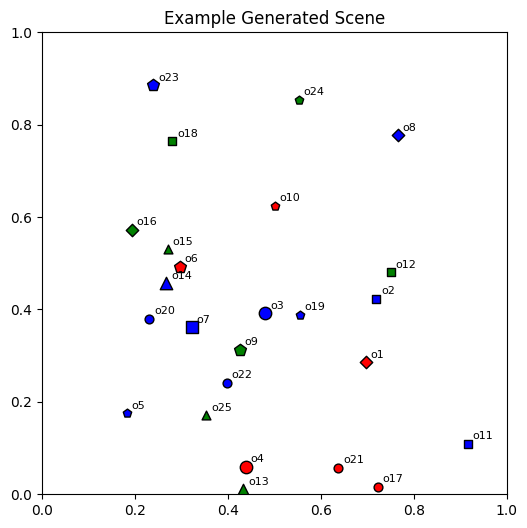

Training (demo mode, 120 epochs)
Epoch 0: sat=0.7351 logic_loss=0.2649 sup_loss=7.5857
Epoch 12: sat=0.7399 logic_loss=0.2601 sup_loss=5.8553
Epoch 24: sat=0.7799 logic_loss=0.2201 sup_loss=3.0587
Epoch 36: sat=0.8149 logic_loss=0.1851 sup_loss=0.9019
Epoch 48: sat=0.8478 logic_loss=0.1522 sup_loss=0.1866
Epoch 60: sat=0.8582 logic_loss=0.1418 sup_loss=0.0477
Epoch 72: sat=0.8607 logic_loss=0.1393 sup_loss=0.0190
Epoch 84: sat=0.8613 logic_loss=0.1387 sup_loss=0.0109
Epoch 96: sat=0.8615 logic_loss=0.1385 sup_loss=0.0078
Epoch 108: sat=0.8616 logic_loss=0.1384 sup_loss=0.0061

Evaluation results:
uniqueness: 0.9992691874504089
coverage: 0.9990935325622559
irreflexive_left: 0.5
asymmetry_left: 0.9600638747215271
inverse: 1.0
transitivity: 0.9959008693695068
closeTo: 0.03691008314490318
inBetween: 0.3387989103794098
lastOnLeft: 0.9522385597229004
lastOnRight: 0.9798107147216797
existsLeftOfAllSquares: 0.9990792870521545
squareRightOfCircle: 0.9825519323348999
inverseBelowAbove: 1.0
trans

In [17]:
# Cell index: 15
if __name__ == '__main__':
    # Quick demo run (short) - reduces epochs to be fast
    feats, labels = generate_scene(n_objects=25, seed=123)
    plot_scene(feats, labels, title='Example Generated Scene')
    unaries = build_predicates()
    print('Training (demo mode, 120 epochs)')
    history = train_ltn(unaries, feats, labels, epochs=120, lr=5e-3, weight_supervision=1.0, verbose=True)
    results = evaluate(unaries, feats, labels)
    print('\nEvaluation results:')
    for k,v in results.items():
        print(f'{k}: {v}')

## **5.3 — Results Finals**

In [18]:
# If you want to run full experiments, uncomment below line (this may take many minutes):
df = experiment_runs(num_datasets=5, runs_per_dataset=5, n_objects=25, epochs=400)
print(df.groupby('dataset').mean())

Dataset 0 run 0 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 0 run 1 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 0 run 2 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 0 run 3 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 0 run 4 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 1 run 0 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.798
Dataset 1 run 1 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.796
Dataset 1 run 2 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.798
Dataset 1 run 3 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.798
Dataset 1 run 4 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.798
Dataset 2 run 0 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 2 run 1 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 2 run 2 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 2 run 3 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 2 run 4 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.861
Dataset 3 